In [ ]:
# 准备环境
!wget https://raw.githubusercontent.com/lhiqwj173/dl_helper/master/envs/rl.py > /dev/null 2>&1
!python rl.py not_install_dl_helper > /dev/null 2>&1
!pip install /kaggle/working/3rd/dl_helper > /dev/null 2>&1

In [ ]:
%%writefile run.py
"""Example of implementing and configuring a custom (torch) CNN containing RLModule.

This example:
    - demonstrates how you can subclass the TorchRLModule base class and set up your
    own CNN-stack architecture by overriding the `setup()` method.
    - shows how to override the 3 forward methods: `_forward_inference()`,
    `_forward_exploration()`, and `forward_train()` to implement your own custom forward
    logic(s). You will also learn, when each of these 3 methods is called by RLlib or
    the users of your RLModule.
    - shows how you then configure an RLlib Algorithm such that it uses your custom
    RLModule (instead of a default RLModule).

We implement a tiny CNN stack here, the exact same one that is used by the old API
stack as default CNN net. It comprises 4 convolutional layers, the last of which
ends in a 1x1 filter size and the number of filters exactly matches the number of
discrete actions (logits). This way, the (non-activated) output of the last layer only
needs to be reshaped in order to receive the policy's logit outputs. No flattening
or additional dense layer required.

The network is then used in a fast ALE/Pong-v5 experiment.


How to run this script
----------------------
`python [script file name].py --enable-new-api-stack`

For debugging, use the following additional command line options
`--no-tune --num-env-runners=0`
which should allow you to set breakpoints anywhere in the RLlib code and
have the execution stop there for inspection and debugging.

For logging to your WandB account, use:
`--wandb-key=[your WandB API key] --wandb-project=[some project name]
--wandb-run-name=[optional: WandB run name (within the defined project)]`


Results to expect
-----------------
You should see the following output (during the experiment) in your console:

Number of trials: 1/1 (1 RUNNING)
+---------------------+----------+----------------+--------+------------------+
| Trial name          | status   | loc            |   iter |   total time (s) |
|                     |          |                |        |                  |
|---------------------+----------+----------------+--------+------------------+
| PPO_env_82b44_00000 | RUNNING  | 127.0.0.1:9718 |      1 |          98.3585 |
+---------------------+----------+----------------+--------+------------------+
+------------------------+------------------------+------------------------+
|   num_env_steps_sample |   num_env_steps_traine |   num_episodes_lifetim |
|             d_lifetime |             d_lifetime |                      e |
|------------------------+------------------------+------------------------|
|                   4000 |                   4000 |                      4 |
+------------------------+------------------------+------------------------+
"""
import gymnasium as gym

from ray.rllib.core.rl_module.rl_module import RLModuleSpec
from ray.rllib.env.wrappers.atari_wrappers import wrap_atari_for_new_api_stack
from ray.rllib.examples.rl_modules.classes.tiny_atari_cnn_rlm import TinyAtariCNN
from ray.rllib.utils.test_utils import (
    add_rllib_example_script_args,
    run_rllib_example_script_experiment,
)
from ray.tune.registry import get_trainable_cls, register_env
import os
from dl_helper.rl.rl_utils import simplify_rllib_metrics

parser = add_rllib_example_script_args(default_iters=100, default_timesteps=600000)
parser.set_defaults(
    enable_new_api_stack=True,
    env="ale_py:ALE/Pong-v5",
)

if __name__ == "__main__":
    args = parser.parse_args()

    register_env(
        "env",
        lambda cfg: wrap_atari_for_new_api_stack(
            gym.make(args.env, **cfg),
            dim=42,  # <- need images to be "tiny" for our custom model
            framestack=4,
        ),
    )

    base_config = (
        get_trainable_cls(args.algo)
        .get_default_config()
        .api_stack(enable_rl_module_and_learner=True, enable_env_runner_and_connector_v2=True)
        .environment(
            env="env",
            env_config=dict(
                frameskip=1,
                full_action_space=False,
                repeat_action_probability=0.0,
            ),
        )
        .framework("torch")
        .env_runners(num_env_runners=2)
        # .resources(num_gpus=2)  # 设置使用2个GPU
        # The following setting is equivalent to the old stack's `config.resources(num_gpus=2)`.
        .learners(
            num_learners=2,
            num_gpus_per_learner=1,
        )
        .rl_module(
            # Plug-in our custom RLModule class.
            rl_module_spec=RLModuleSpec(
                module_class=TinyAtariCNN,
                # Feel free to specify your own `model_config` settings below.
                # The `model_config` defined here will be available inside your
                # custom RLModule class through the `self.model_config`
                # property.
                model_config={
                    "conv_filters": [
                        # num filters, kernel wxh, stride wxh, padding type
                        [16, 4, 2, "same"],
                        [32, 4, 2, "same"],
                        [256, 11, 1, "valid"],
                    ],
                },
            ),
        )
    )


    checkpoint_base_dir = 'checkpoints'
    os.makedirs(checkpoint_base_dir, exist_ok=True)

    # 构建算法
    algo = base_config.build()

    # 训练循环
    rounds = 50000
    for i in range(rounds):
        print(f"\nTraining iteration {i+1}/{rounds}")
        result = algo.train()
        simplify_rllib_metrics(result)
        
        if (i + 1) % 5 == 0:
            checkpoint_dir = algo.save_to_path(
                os.path.join(os.path.abspath(checkpoint_base_dir), f"checkpoint_{i+1}")
            )
            print(f"Checkpoint saved in directory {checkpoint_dir}")

    # 保存最终模型
    final_checkpoint = algo.save_to_path(
        os.path.join(os.path.abspath(checkpoint_base_dir), f"final")
    )
    print(f"Final checkpoint saved in directory {final_checkpoint}")

    # 清理
    algo.stop()

In [ ]:
!python run.py

# 回报曲线

In [4]:
line = '213.8s 85 episode平均回报: -20.2500' 
float(line.strip().split('s ')[0])

213.8

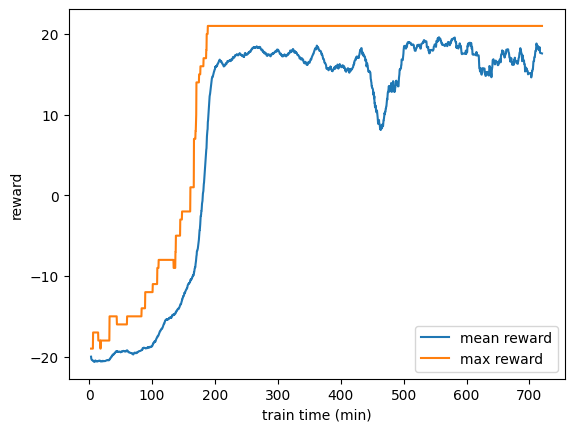

In [7]:
# 读取数据
file = r'rllib-pong-v5.log'
times = []
episode_reward_means = []
episode_reward_maxs = []
with open(file, 'r') as f:
    for line in f:
        if 'episode平均回报' in line:
            episode_reward_means.append(float(line.strip().split('回报: ')[-1]))
        elif 'episode最大回报' in line:
            episode_reward_maxs.append(float(line.strip().split('回报: ')[-1]))
            times.append(float(line.strip().split('s ')[0]))

# 绘制曲线
import matplotlib.pyplot as plt
times = [t/60 for t in times]
plt.plot(times, episode_reward_means, label='mean reward') 
plt.plot(times, episode_reward_maxs, label='max reward')
plt.xlabel('train time (min)')
plt.ylabel('reward')
plt.legend()
plt.show()